In [1]:
import sqlalchemy as sql
import pandas as pd
import datetime

from ipynb.fs.full.help_functions import query_data

pd.set_option("display.max.columns", None)
%matplotlib inline
db_connect = query_data()
engine = sql.create_engine(db_connect)

pd.set_option('mode.chained_assignment',None)

In [2]:
connection = engine.connect()
metadata = sql.MetaData()
oblamatik = sql.Table('oblamatik', metadata, autoload=True, autoload_with=engine)
query = sql.select(oblamatik).order_by('tstamp')
ResultSet = connection.execute(query).fetchall()
data_oblamatik = pd.DataFrame(ResultSet)
data_oblamatik.columns = ResultSet[0].keys()
data_oblamatik.drop(columns='id_col')

,tstamp,Anergie_Kälte_kW,Anergie_Kälte_kWh,Anergie_Wärme_kW,Anergie_Wärme_kWh,Betriebsmodus,Bo_Heizen_Ein,Bo_Kühlen_Ein,E_Allgemein_kW,E_Allgemein_kWh,E_EG_1_kW,E_EG_1_kWh,E_EG_2_kW,E_EG_2_kWh,E_EG_3_kW,E_EG_3_kWh,E_HauptVerteilung_Einspeisung_kW,E_HauptVerteilung_kW,E_HauptVerteilung_kWh,E_Lüftung_kW,E_Lüftung_kWh,E_MSRL_kW,E_MSRL_kWh,E_Netzbezug_kW,E_Netzbezug_kWh,E_OG1_1_kW,E_OG1_1_kWh,E_OG1_2_kW,E_OG1_2_kWh,E_OG1_3_kW,E_OG1_3_kWh,E_OG2_kW,E_OG2_kWh,E_PVT_kW,E_PVT_kWh,E_Pumpe_Fund_kW,E_Pumpe_Fund_kWh,E_Pumpe_Heizung_Lüftung_kW,E_Pumpe_Heizung_Lüftung_kWh,E_Pumpe_Notkühlung_kW,E_Pumpe_Notkühlung_kWh,E_Pumpe_PVT_kW,E_Pumpe_PVT_kWh,E_Pumpe_Rückkühlung_kW,E_Pumpe_Rückkühlung_kWh,E_Stab_Speicher_kW,E_Stab_Speicher_kWh,E_Technikraum_kW,E_Technikraum_kWh,E_USV_kW,E_USV_kWh,E_WP1_kW,E_WP1_kWh,E_WP2_kW,E_WP2_kWh,Energiemessung HV2.UG bezogen,Energiemessung HV2.UG geliefert,Fund_KälteReg_kW,Fund_KälteReg_kWh,Fund_WärmeReg_TRL,Fund_WärmeReg_TVL,Fund_WärmeReg_Vol,Fund_WärmeReg_kW,Fund_WärmeReg_kWh,Gastro_Abw_kW,Gastro_Abw_kWh,Globalstrahlung,Heizen_Anergie_Ein,Heizen_Fund_Ein,Heizung_Deckensegel_FBH_kW,Heizung_Deckensegel_FBH_kWh,Heizung_Lüftung_kW,Heizung_Lüftung_kWh,Heizung_Status,Kühlen_Anergie_Ein,Kühlen_FreeCool_Fund_Ein,Kühlen_Fund_Ein,Kühlung_Deckensegel_FBH_kW,Kühlung_Deckensegel_FBH_kWh,Kühlung_Lüftung_kW,Kühlung_Lüftung_kWh,Kühlung_Server_kW,Kühlung_Server_kWh,Kühlung_Status,Notkühlung_Gastro_kW,Notkühlung_Gastro_kWh,PVT_BWW_Ein,PVT_BWW_TRL,PVT_BWW_TVL,PVT_BWW_Vol,PVT_BWW_kW,PVT_BWW_kWh,PVT_Heizung_Ein,PVT_KälteReg_Ein,PVT_Kühlung_Ein,PVT_Kühlung_Fund_kW,PVT_Kühlung_Fund_kWh,PVT_WärmeReg_Ein,PVT_Wärme_Fund_TRL,PVT_Wärme_Fund_TVL,PVT_Wärme_Fund_Vol,PVT_Wärme_Fund_kW,PVT_Wärme_Fund_kWh,T_Erdreich_201,T_Erdreich_203,T_Erdreich_205,T_Erdreich_301,T_Erdreich_303,T_Erdreich_305,T_Erdreich_401_ung,T_Erdreich_403_ung,T_Erdreich_405_ung,T_Fund_11,T_Fund_12,T_Fund_13,T_Fund_14,T_Fund_21,T_Fund_22,T_Fund_23,T_Fund_24,T_Fund_31,T_Fund_32,T_Fund_33,T_Fund_34,T_Lagerraum_Mitte,T_Lagerraum_Nord,T_Lagerraum_Süd,T_PVT_1,T_PVT_2,T_PVT_3,T_Raumsoll,T_amb,T_amb24h,WP1_Kond_BWW_TRL,WP1_Kond_BWW_TVL,WP1_Kond_BWW_Vol,WP1_Kond_BWW_kW,WP1_Kond_BWW_kWh,WP1_Kond_TRL,WP1_Kond_TVL,WP1_Kond_Tin,WP1_Kond_Tout,WP1_Kond_Vol,WP1_Kond_kW,WP1_Kond_kWh,WP1_Status,WP1_Verd_TRL,WP1_Verd_TVL,WP1_Verd_Vol,WP1_Verd_kW,WP1_Verd_kWh,WP2_Kond_TRL,WP2_Kond_TVL,WP2_Kond_Vol,WP2_Kond_kW,WP2_Kond_kWh,WP2_Status,WP2_Verd_TRL,WP2_Verd_TVL,WP2_Verd_Vol,WP2_Verd_kW,WP2_Verd_kWh,WRG_Speicher_TRL,WRG_Speicher_TVL,WRG_Speicher_Vol,WRG_Speicher_kW,WRG_Speicher_kW_neg,WRG_Speicher_kWh
0,2020-07-04 00:00:00,-1.6,1194.0,0.0,4237.0,0.0,False,True,26.042000,306800.62500,8.989,76851.648438,0.095,18151.929688,1.008,9123.269531,0.0,45.970001,380576.28125,0.045,20436.0,3.284,91671.570312,2.682,9633.950195,0.507,3303.610107,3.726,33570.421875,0.000000,0.000,0.393,10702.089844,0.0,0.000000,0.0,1.6,0.5,1336.0,0.0,5857.6,0.9,5851.7,0.1,1443.8,0.0,14564.3,2.190,-2.347703e+09,2.715,24241.650391,25.836,88932.273438,15.435,3.760024e+04,NaN,NaN,0.0,52610.0,30.1,31.6,22.1,38.6,88171.0,0.0,0.0,0.0,0.0,0.0,0.0,188688.0,0.0,46040.0,0.0,0.0,0.0,0.0,49.5,94957.0,0.0,19298.0,3.1,23330.0,10.0,3.3,8918.0,0.0,26.3,25.9,0.4,-0.2,7665.0,0.0,10.0,10.0,0.0,6537.0,0.0,20.5,33.3,2.7,37.0,48423.0,21.4,16.1,13.2,21.2,15.8,13.4,12.2,11.6,11.3,28.0,27.7,28.3,28.8,28.1,28.1,27.8,22.1,28.3,28.3,27.9,28.2,24.3,24.5,25.0,23.6,17.3,15.6,0.0,20.6,21.1,33.4,33.2,0.0,0.0,32904.0,34.8,43.2,35.6,44.5,8.7,83.9,160626.0,10.0,20.2,15.8,13.8,-69.8,351.0,27.8,29.2,0.0,0.0,163266.0,0.0,23.7,21.9,0.0,0.0,414.0,NaN,NaN,NaN,14.1,0.0,72106.0
1,2020-07-04 00:01:00,-1.6,1194.0,-2.4,4237.0,0.0,False,True,32.348999,306801.06250,8.865,76851.812500,0.061,18151.929688,0.915,9123.290039,0.0,50.998001,380577.03125,0.045,20436.0,3.756,91671.632812,2.682,9633.950195,0.502,3303.620117,2.495,33570.460938,0.000000,0.000,0.409,10702.089844,0.0,0.000000,0.0,1.6,0.2,1336.0,0.0,5857.6,0.9,5851.7,0.1,1443.8,0.0,14564.3,1.830,-2.347703e+09,2.722,24241.689453

In [3]:
import pandas as pd
import numpy as np
from math import pi
from bokeh.plotting import figure, output_notebook, show
from bokeh.palettes import Spectral8, Spectral5, Category20c
from bokeh.layouts import row, column
from bokeh.transform import dodge, cumsum, factor_cmap
from bokeh.models import ColumnDataSource, FactorRange, HoverTool
import math
import matplotlib.pyplot as plt

def check_consecutive_nan(data, col):
    return max(data[col].isnull().astype(int).groupby(data[col].notnull().astype(int).cumsum()).sum())
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def calc_percentage_error(approx,exact):
    return np.divide(abs(approx - exact),abs(exact))

def fun_calc_mean(data,name,count_entries_per_day,cond=0):
    # cond =  1: Only consider values for which "Bo_Heizen_Ein" == True
    # cond = -1: Only consider values for which "Bo_Kühlen_Ein" == True
    index = row_index = 0
    output = np.zeros(len(count_entries_per_day.keys()))
    for key in count_entries_per_day.keys():
        if cond == 1:
            output[index] = sum(data.loc[row_index:row_index+count_entries_per_day[key],name].abs()*data.loc[row_index:row_index+count_entries_per_day[key],"Bo_Heizen_Ein"])/count_entries_per_day[key]
        elif cond == -1:
            output[index] = sum(data.loc[row_index:row_index+count_entries_per_day[key],name].abs()*data.loc[row_index:row_index+count_entries_per_day[key],"Bo_Kühlen_Ein"])/count_entries_per_day[key]
        elif cond == 2:
            output[index] = sum(abs(data.loc[row_index:row_index+count_entries_per_day[key],name]))/count_entries_per_day[key]
        else:
            output[index] = sum(data.loc[row_index:row_index+count_entries_per_day[key],name])/count_entries_per_day[key]
        index += 1
        row_index += count_entries_per_day[key]
    return output_notebook

# NaNs (missing entries)

## Number of NaNs

In [4]:
pd.set_option('display.max_rows', None)
data_oblamatik.isna().sum()

id_col                                   0
tstamp                                   0
Anergie_Kälte_kW                       395
Anergie_Kälte_kWh                      395
Anergie_Wärme_kW                       395
Anergie_Wärme_kWh                      395
Betriebsmodus                          395
Bo_Heizen_Ein                          395
Bo_Kühlen_Ein                          395
E_Allgemein_kW                         395
E_Allgemein_kWh                        395
E_EG_1_kW                              395
E_EG_1_kWh                             395
E_EG_2_kW                              395
E_EG_2_kWh                             395
E_EG_3_kW                              395
E_EG_3_kWh                             395
E_HauptVerteilung_Einspeisung_kW       395
E_HauptVerteilung_kW                   395
E_HauptVerteilung_kWh                  395
E_Lüftung_kW                           395
E_Lüftung_kWh                          395
E_MSRL_kW                              395
E_MSRL_kWh 

## Longest sequence of NaNs

In [5]:
cols = list(data_oblamatik.columns[data_oblamatik.isna().sum()>0])
cols.remove('Bo_Heizen_Ein')
cols.remove('Bo_Kühlen_Ein')
longest_sequence = {}

for col in cols:
    longest_sequence[col] = check_consecutive_nan(data_oblamatik,col)
    
longest_sequence

{'Anergie_Kälte_kW': 1,
 'Anergie_Kälte_kWh': 1,
 'Anergie_Wärme_kW': 1,
 'Anergie_Wärme_kWh': 1,
 'Betriebsmodus': 1,
 'E_Allgemein_kW': 1,
 'E_Allgemein_kWh': 1,
 'E_EG_1_kW': 1,
 'E_EG_1_kWh': 1,
 'E_EG_2_kW': 1,
 'E_EG_2_kWh': 1,
 'E_EG_3_kW': 1,
 'E_EG_3_kWh': 1,
 'E_HauptVerteilung_Einspeisung_kW': 1,
 'E_HauptVerteilung_kW': 1,
 'E_HauptVerteilung_kWh': 1,
 'E_Lüftung_kW': 1,
 'E_Lüftung_kWh': 1,
 'E_MSRL_kW': 1,
 'E_MSRL_kWh': 1,
 'E_Netzbezug_kW': 1,
 'E_Netzbezug_kWh': 1,
 'E_OG1_1_kW': 1,
 'E_OG1_1_kWh': 1,
 'E_OG1_2_kW': 1,
 'E_OG1_2_kWh': 1,
 'E_OG1_3_kW': 1,
 'E_OG1_3_kWh': 1,
 'E_OG2_kW': 1,
 'E_OG2_kWh': 1,
 'E_PVT_kW': 1,
 'E_PVT_kWh': 1,
 'E_Pumpe_Fund_kW': 1,
 'E_Pumpe_Fund_kWh': 1,
 'E_Pumpe_Heizung_Lüftung_kW': 1,
 'E_Pumpe_Heizung_Lüftung_kWh': 1,
 'E_Pumpe_Notkühlung_kW': 1,
 'E_Pumpe_Notkühlung_kWh': 1,
 'E_Pumpe_PVT_kW': 1,
 'E_Pumpe_PVT_kWh': 1,
 'E_Pumpe_Rückkühlung_kW': 1,
 'E_Pumpe_Rückkühlung_kWh': 1,
 'E_Stab_Speicher_kW': 1,
 'E_Stab_Speicher_kWh': 1,
 '

## Number of negative entries

In [6]:
negative_columns = dict()

for col in cols:
    negative_columns[col] = sum(data_oblamatik.loc[:,col] < 0)
    
negative_columns

{'Anergie_Kälte_kW': 127496,
 'Anergie_Kälte_kWh': 0,
 'Anergie_Wärme_kW': 65243,
 'Anergie_Wärme_kWh': 0,
 'Betriebsmodus': 0,
 'E_Allgemein_kW': 0,
 'E_Allgemein_kWh': 0,
 'E_EG_1_kW': 0,
 'E_EG_1_kWh': 0,
 'E_EG_2_kW': 0,
 'E_EG_2_kWh': 0,
 'E_EG_3_kW': 0,
 'E_EG_3_kWh': 0,
 'E_HauptVerteilung_Einspeisung_kW': 0,
 'E_HauptVerteilung_kW': 0,
 'E_HauptVerteilung_kWh': 0,
 'E_Lüftung_kW': 434,
 'E_Lüftung_kWh': 0,
 'E_MSRL_kW': 0,
 'E_MSRL_kWh': 0,
 'E_Netzbezug_kW': 0,
 'E_Netzbezug_kWh': 0,
 'E_OG1_1_kW': 0,
 'E_OG1_1_kWh': 0,
 'E_OG1_2_kW': 0,
 'E_OG1_2_kWh': 0,
 'E_OG1_3_kW': 0,
 'E_OG1_3_kWh': 0,
 'E_OG2_kW': 0,
 'E_OG2_kWh': 0,
 'E_PVT_kW': 133256,
 'E_PVT_kWh': 0,
 'E_Pumpe_Fund_kW': 0,
 'E_Pumpe_Fund_kWh': 0,
 'E_Pumpe_Heizung_Lüftung_kW': 0,
 'E_Pumpe_Heizung_Lüftung_kWh': 0,
 'E_Pumpe_Notkühlung_kW': 0,
 'E_Pumpe_Notkühlung_kWh': 0,
 'E_Pumpe_PVT_kW': 0,
 'E_Pumpe_PVT_kWh': 0,
 'E_Pumpe_Rückkühlung_kW': 0,
 'E_Pumpe_Rückkühlung_kWh': 0,
 'E_Stab_Speicher_kW': 0,
 'E_Stab_Spei

# Number of entries per day, month, ...

In [7]:
# count_entries_per_year: counts the number of samples in each year
# count_entries_per_month: counts the number of samples in each month of the year
# count_entries_per_day: counts the number of samples in each day (should be around 1440 if data recording worked fine)
# count_entries_per_hour: counts the number of samples in each hour of the day
# count_days_in_month: counts the number days on which data were recorded

count_entries_per_year = dict()
count_entries_per_month = dict()
count_entries_per_day = dict()
count_entries_per_hour = dict()
count_days_in_month = dict()
for rows in range(data_oblamatik["tstamp"].size):
    count_entries_per_year[data_oblamatik.loc[rows,'tstamp'].strftime("%Y")] = count_entries_per_year.get(data_oblamatik.loc[rows,"tstamp"].strftime("%Y"),0) + 1
    count_entries_per_month[data_oblamatik.loc[rows,"tstamp"].strftime("%Y-%m")] = count_entries_per_month.get(data_oblamatik.loc[rows,"tstamp"].strftime("%Y-%m"),0) + 1
    count_entries_per_day[data_oblamatik.loc[rows,"tstamp"].strftime("%Y-%m-%d")] = count_entries_per_day.get(data_oblamatik.loc[rows,"tstamp"].strftime("%Y-%m-%d"),0) + 1
    count_entries_per_hour[data_oblamatik.loc[rows,"tstamp"].strftime("%Y-%m-%d %H")] = count_entries_per_hour.get(data_oblamatik.loc[rows,"tstamp"].strftime("%Y-%m-%d %H"),0) + 1
        
for key in count_entries_per_day.keys():
    count_days_in_month[key[:7]] = count_days_in_month.get(key[:7],0) + 1

In [8]:
count_days_in_month

{'2020-07': 28,
 '2020-08': 26,
 '2020-09': 30,
 '2020-10': 31,
 '2020-11': 30,
 '2020-12': 31,
 '2021-01': 31,
 '2021-02': 28,
 '2021-03': 31,
 '2021-04': 25,
 '2021-05': 31,
 '2021-06': 30,
 '2021-07': 30,
 '2021-08': 17}

In [9]:
data_oblamatik['WP1_Status'].value_counts()

0.0     299802
10.0    271495
1.0          8
2.0          5
Name: WP1_Status, dtype: int64

In [10]:
data_oblamatik['WP2_Status'].value_counts()

0.0     350102
10.0    221201
2.0          4
1.0          3
Name: WP2_Status, dtype: int64

In [11]:
data_oblamatik['WP2_Status'].value_counts()

0.0     350102
10.0    221201
2.0          4
1.0          3
Name: WP2_Status, dtype: int64

<AxesSubplot:>

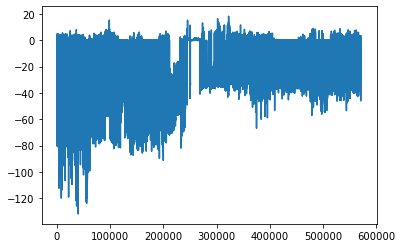

In [12]:
data_oblamatik['WP1_Verd_kW'].plot()

<AxesSubplot:>

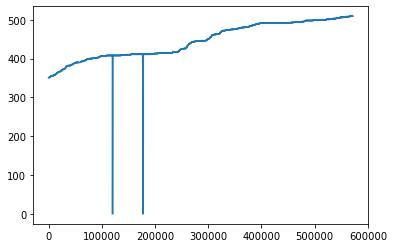

In [13]:
data_oblamatik['WP1_Verd_kWh'].plot()

<AxesSubplot:>

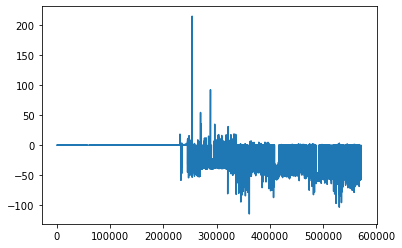

In [14]:
data_oblamatik['WP2_Verd_kW'].plot()

<AxesSubplot:>

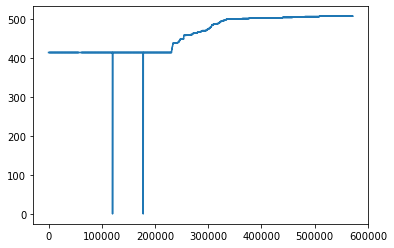

In [15]:
data_oblamatik['WP2_Verd_kWh'].plot()

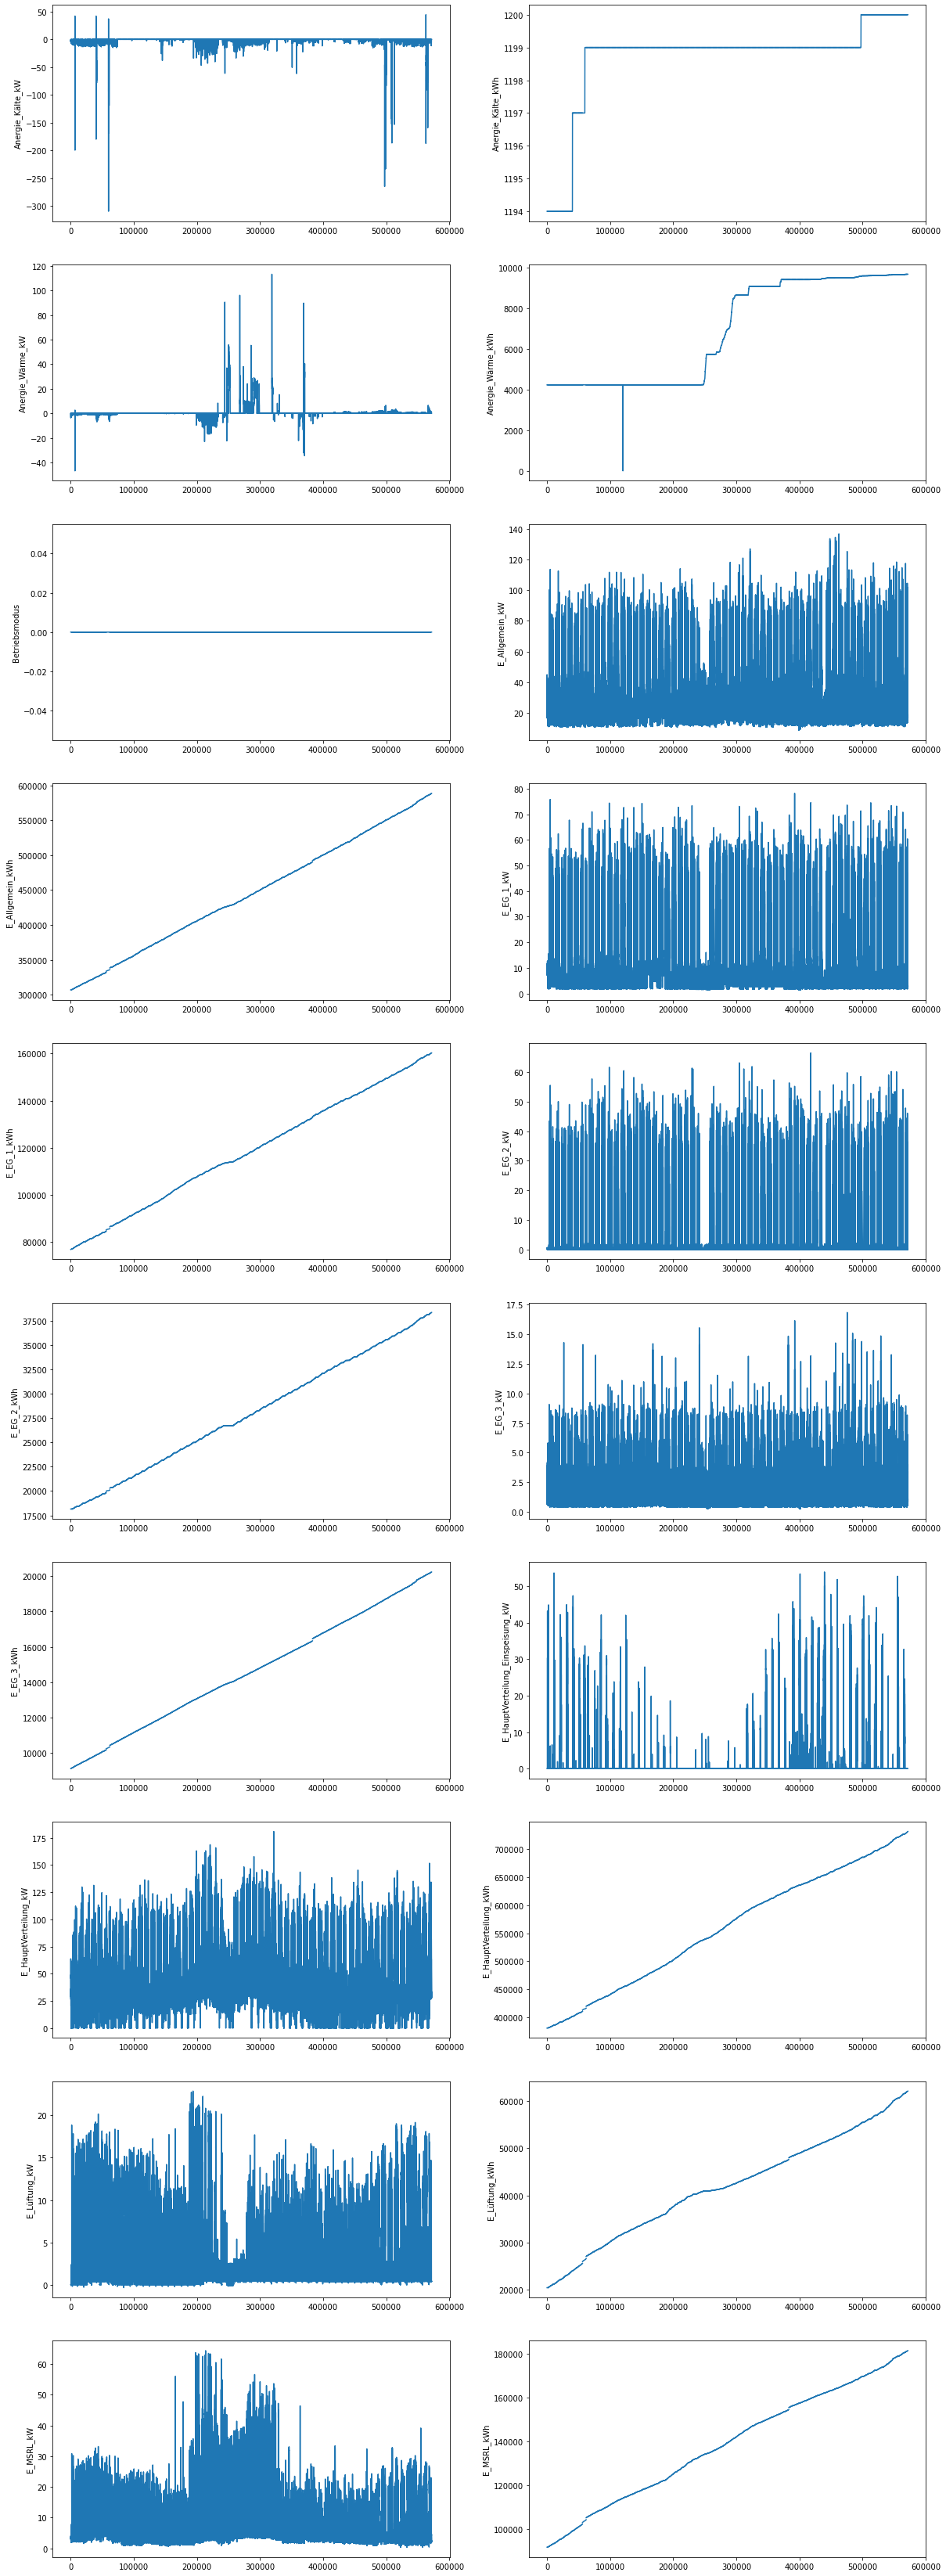

In [16]:
i,j=0,0
PLOTS_PER_ROW = 2
fig, axs = plt.subplots(math.ceil(20/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))
for col in cols[:20]:
    axs[i][j].plot(data_oblamatik[col])
    axs[i][j].set_ylabel(col)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()

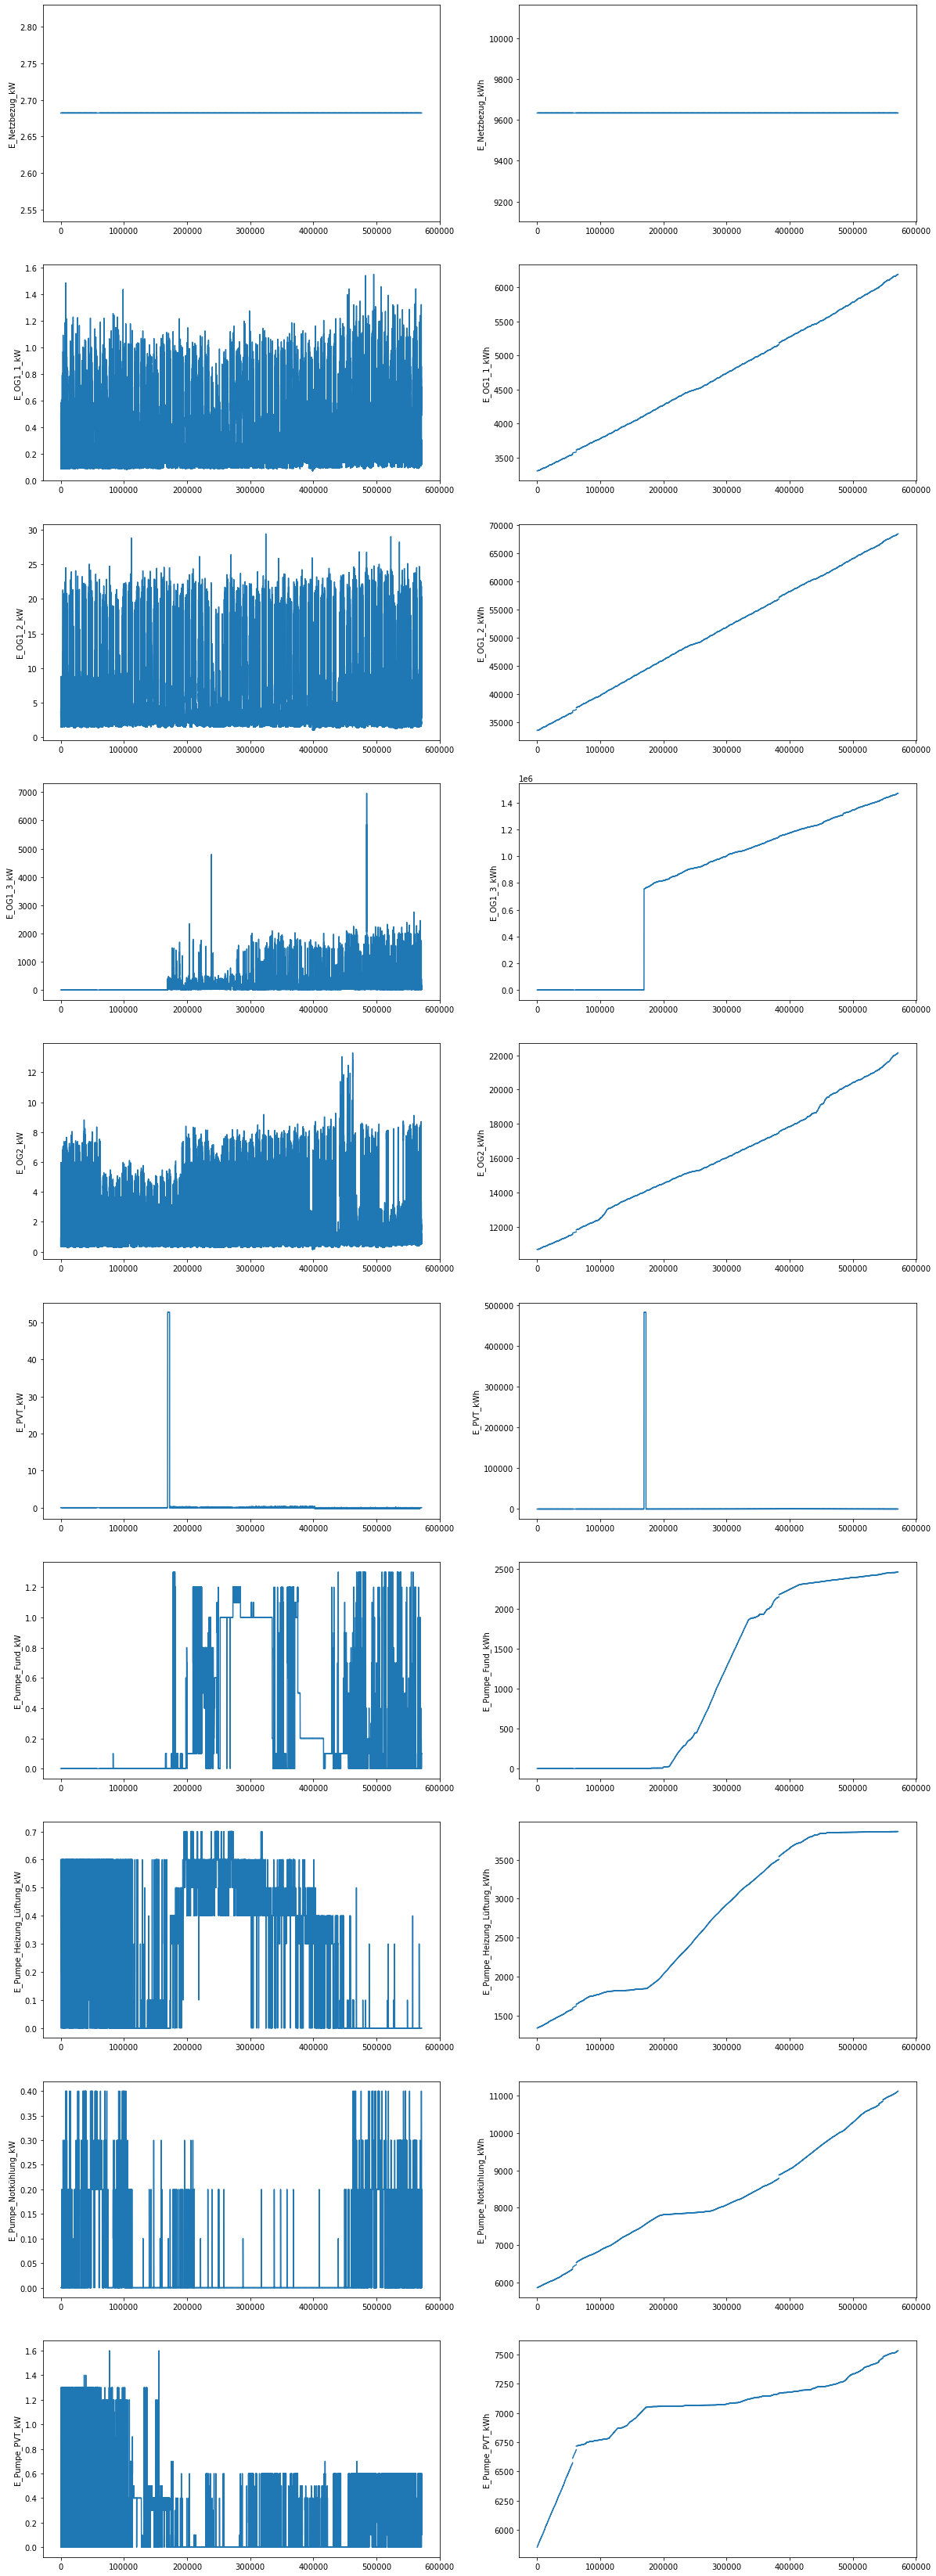

In [17]:
i,j=0,0
PLOTS_PER_ROW = 2
fig, axs = plt.subplots(math.ceil(20/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))
for col in cols[20:40]:
    axs[i][j].plot(data_oblamatik[col])
    axs[i][j].set_ylabel(col)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()

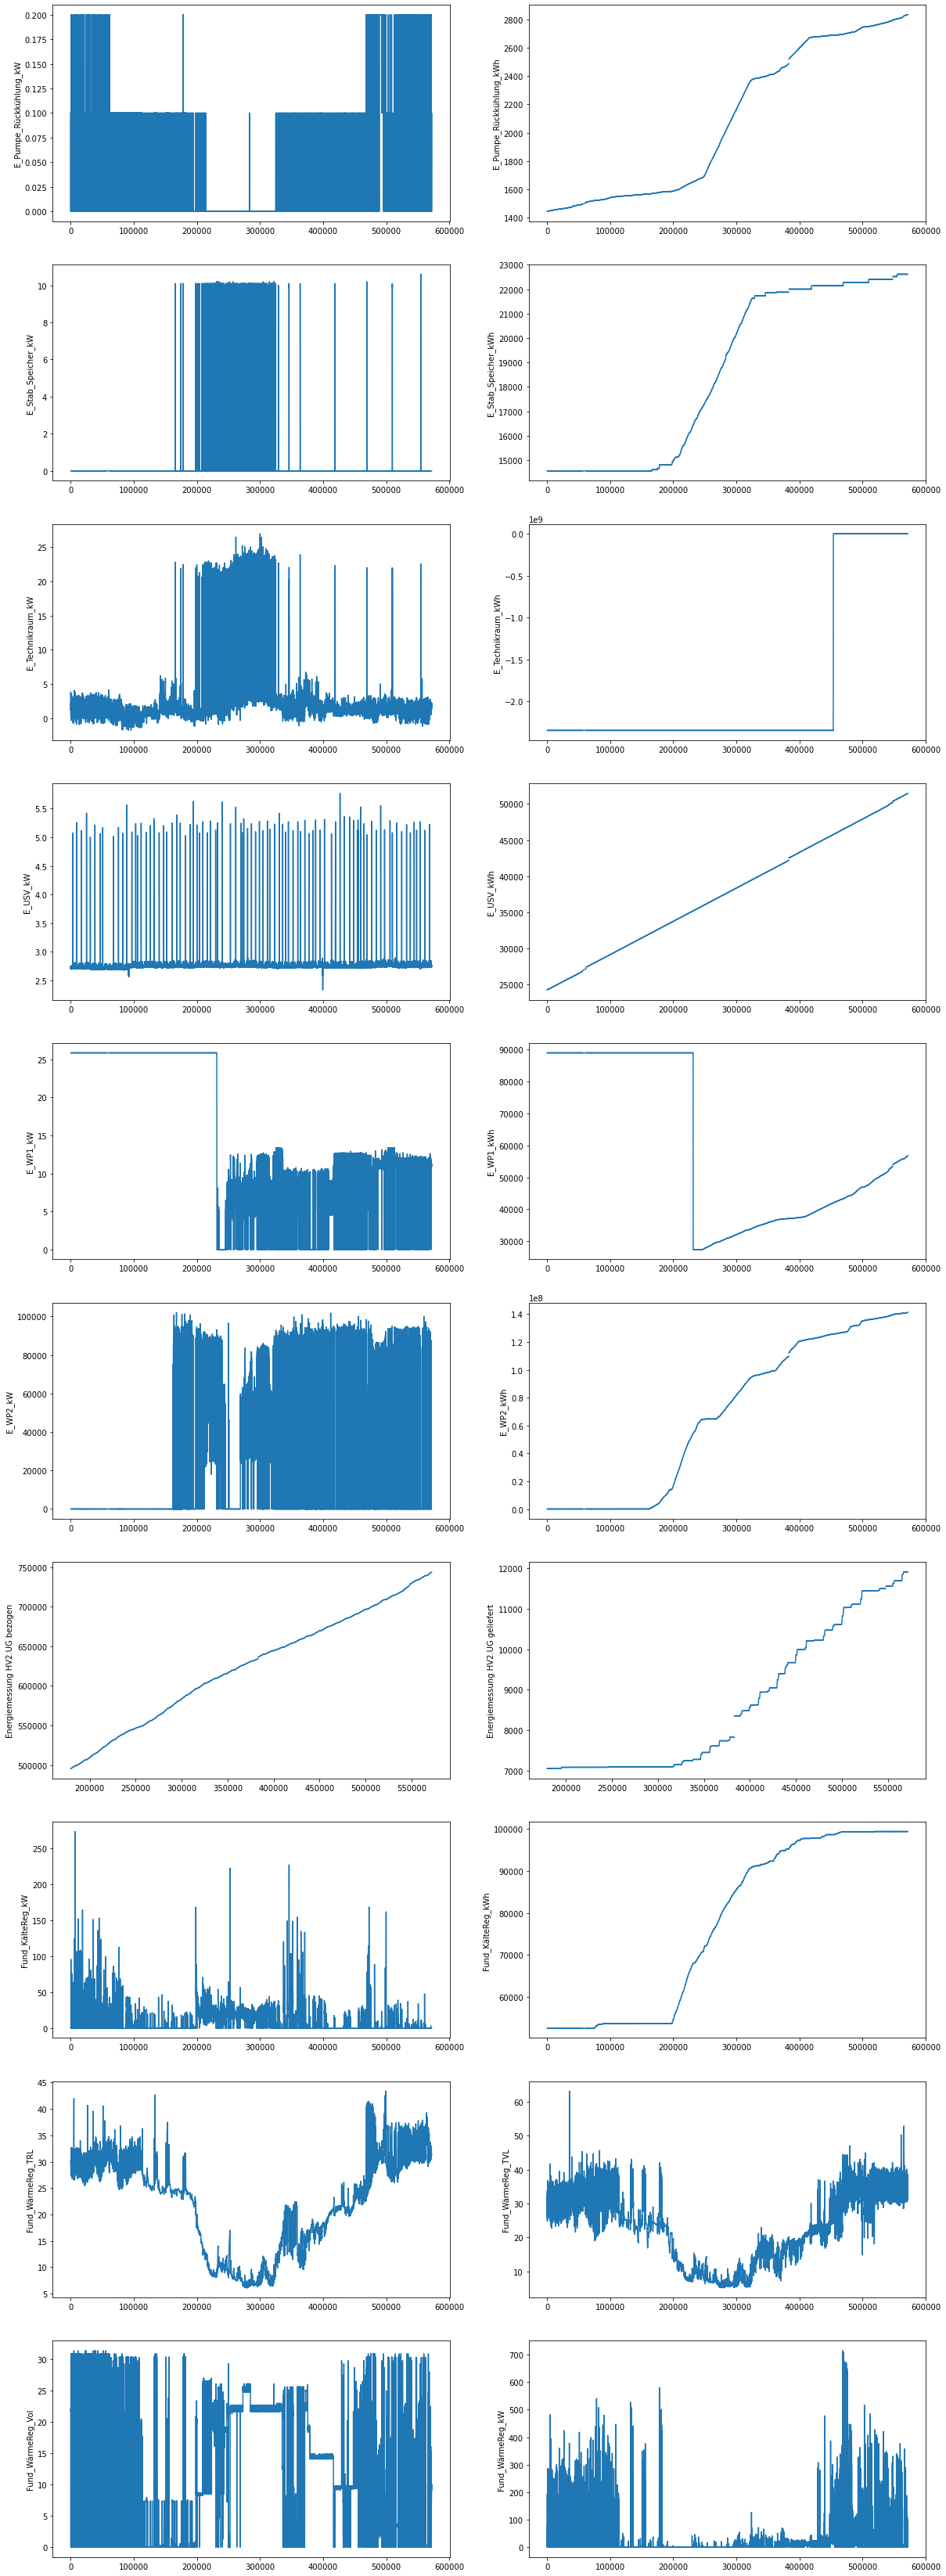

In [18]:
i,j=0,0
PLOTS_PER_ROW = 2
fig, axs = plt.subplots(math.ceil(20/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))
for col in cols[40:60]:
    axs[i][j].plot(data_oblamatik[col])
    axs[i][j].set_ylabel(col)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()

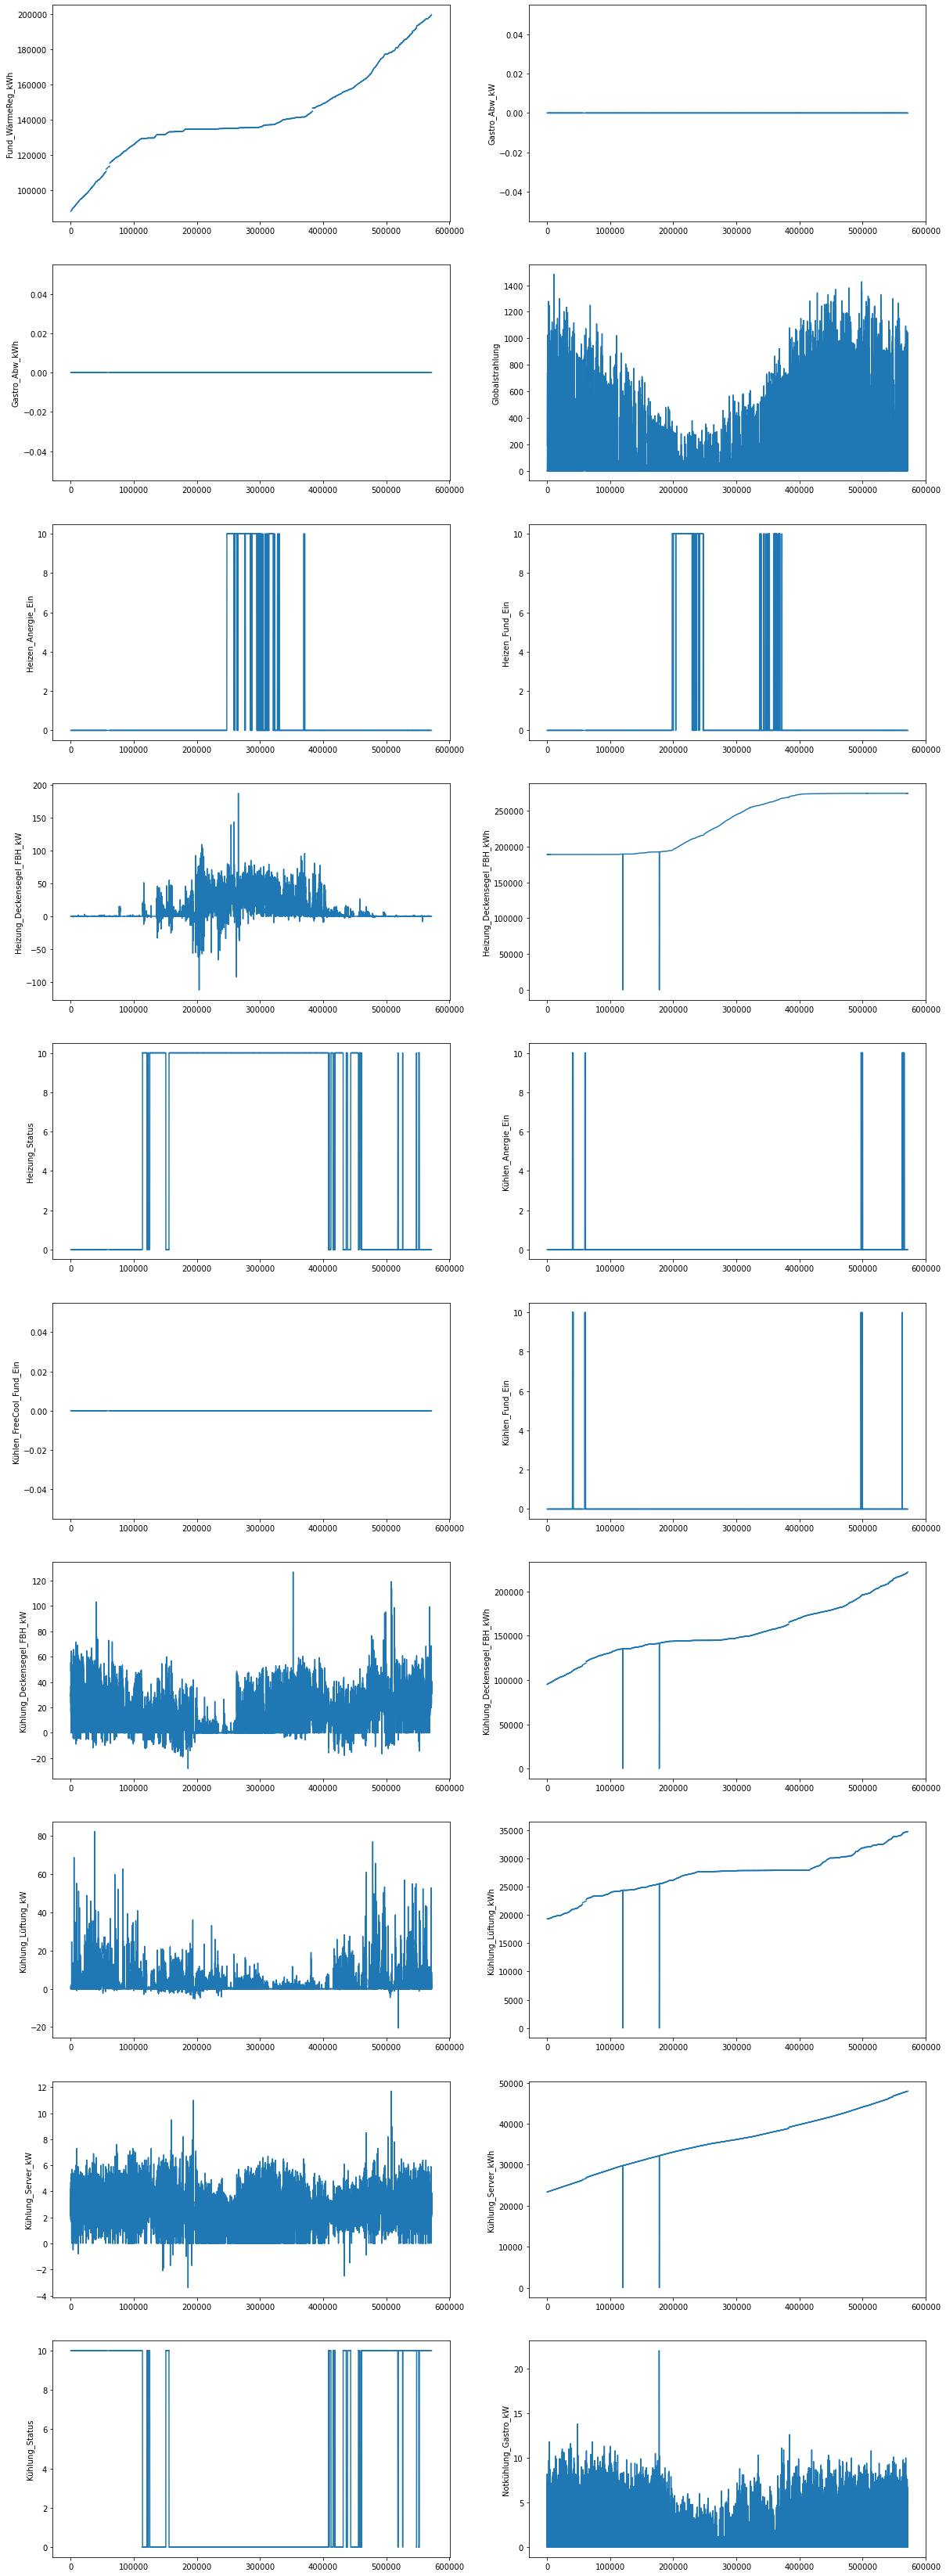

In [19]:
i,j=0,0
PLOTS_PER_ROW = 2
fig, axs = plt.subplots(math.ceil(20/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))
for col in cols[60:80]:
    axs[i][j].plot(data_oblamatik[col])
    axs[i][j].set_ylabel(col)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()

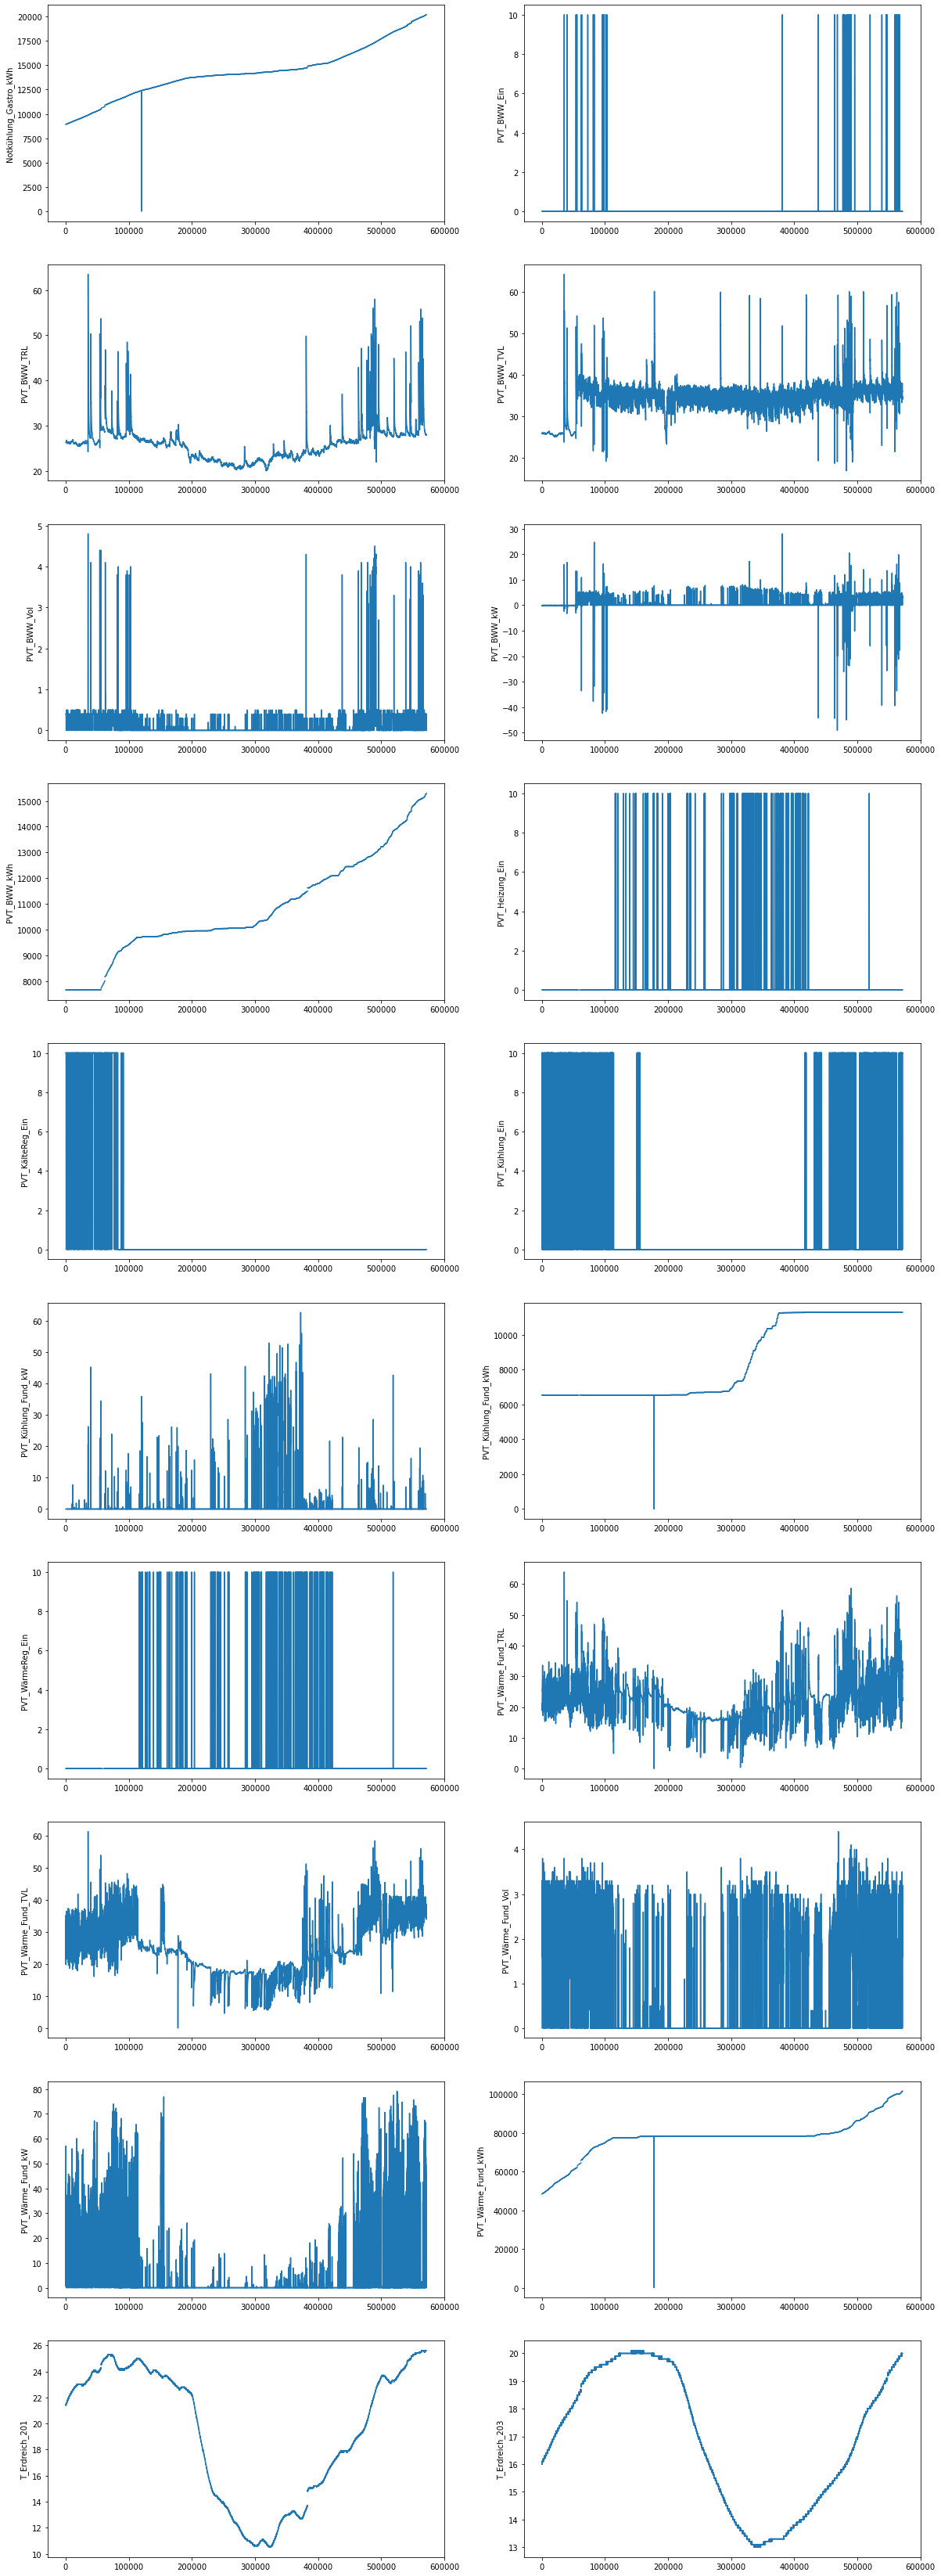

In [20]:
i,j=0,0
PLOTS_PER_ROW = 2
fig, axs = plt.subplots(math.ceil(20/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))
for col in cols[80:100]:
    axs[i][j].plot(data_oblamatik[col])
    axs[i][j].set_ylabel(col)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()

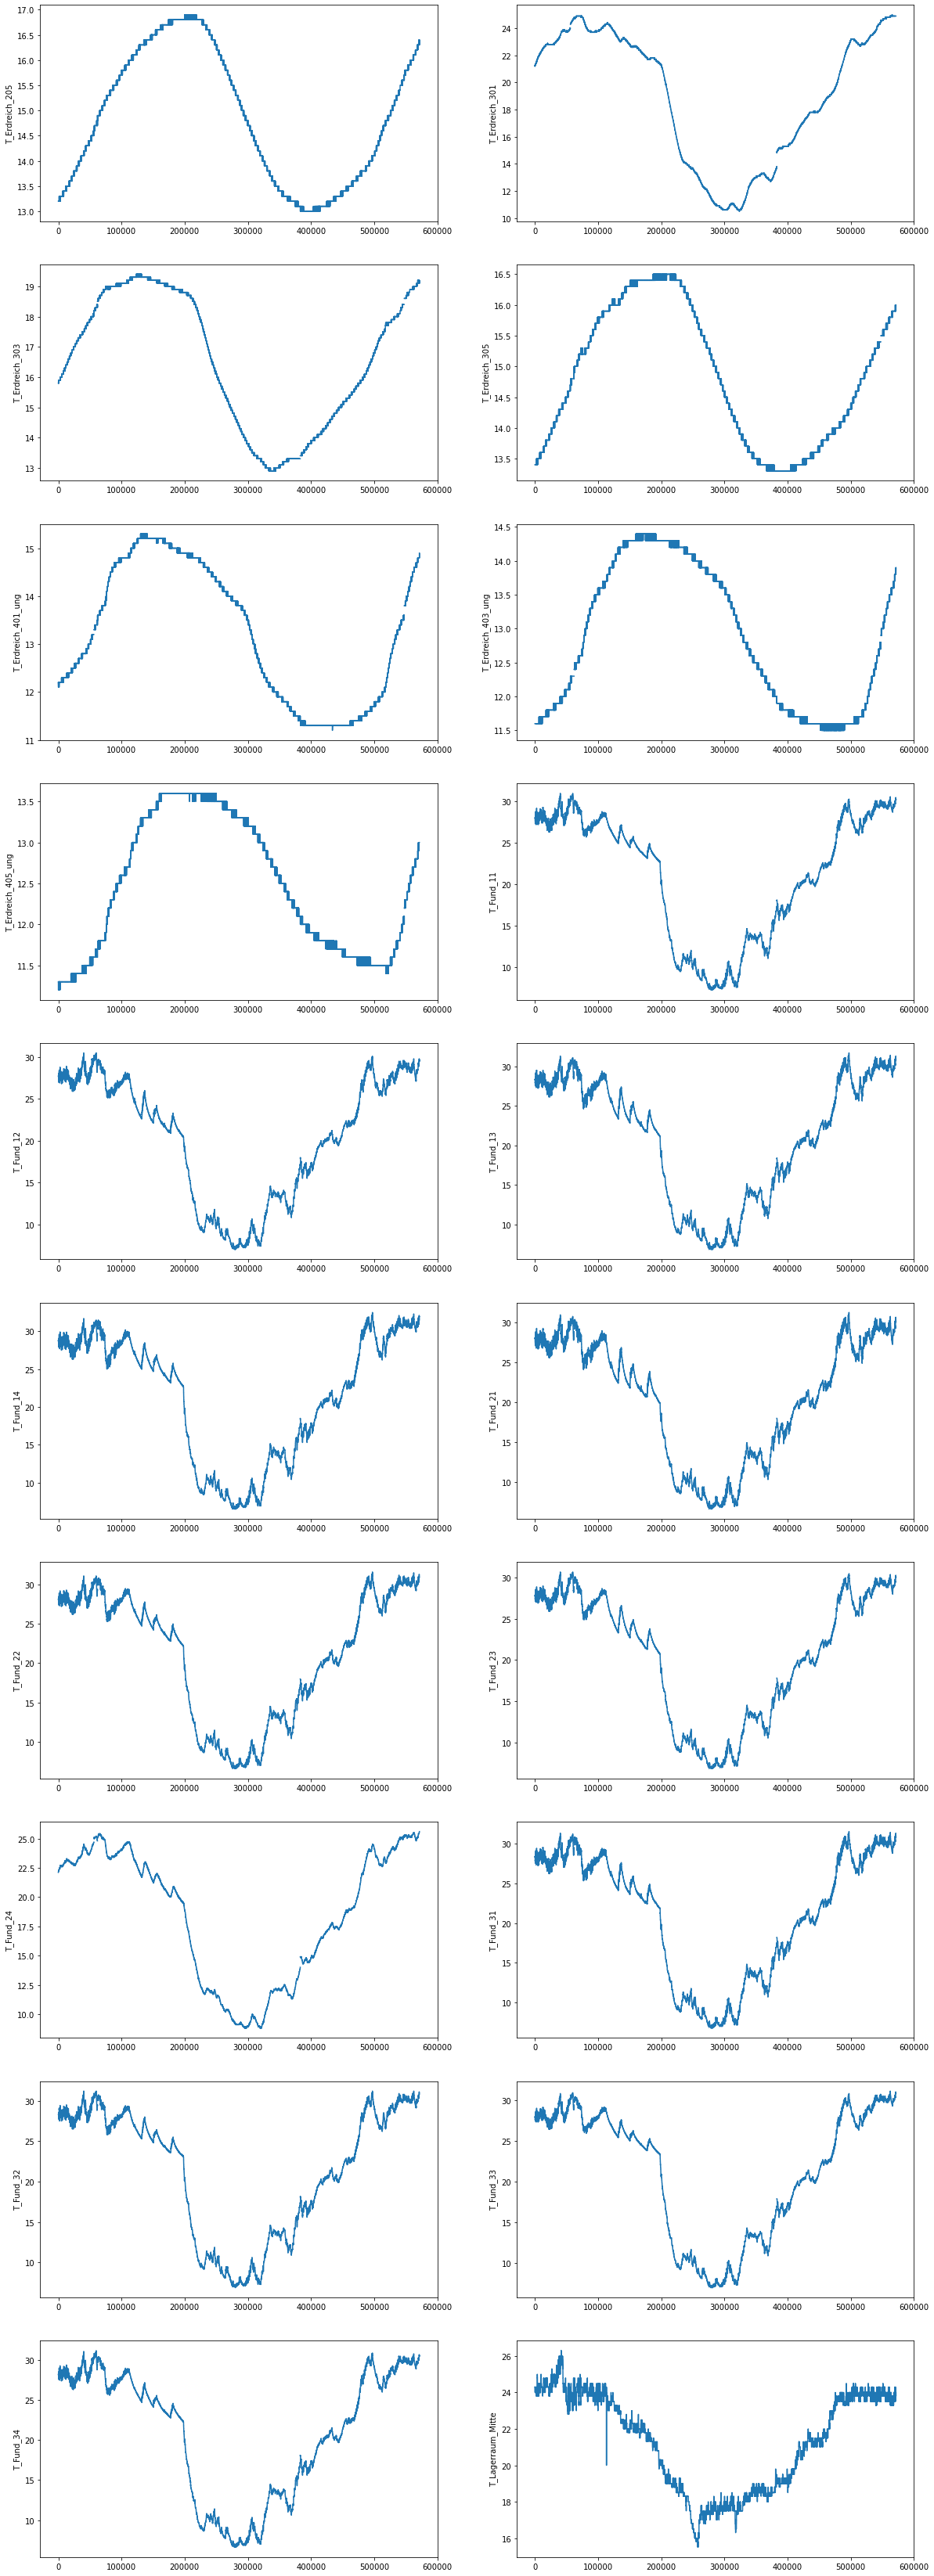

In [21]:
i,j=0,0
PLOTS_PER_ROW = 2
fig, axs = plt.subplots(math.ceil(20/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))
for col in cols[100:120]:
    axs[i][j].plot(data_oblamatik[col])
    axs[i][j].set_ylabel(col)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()

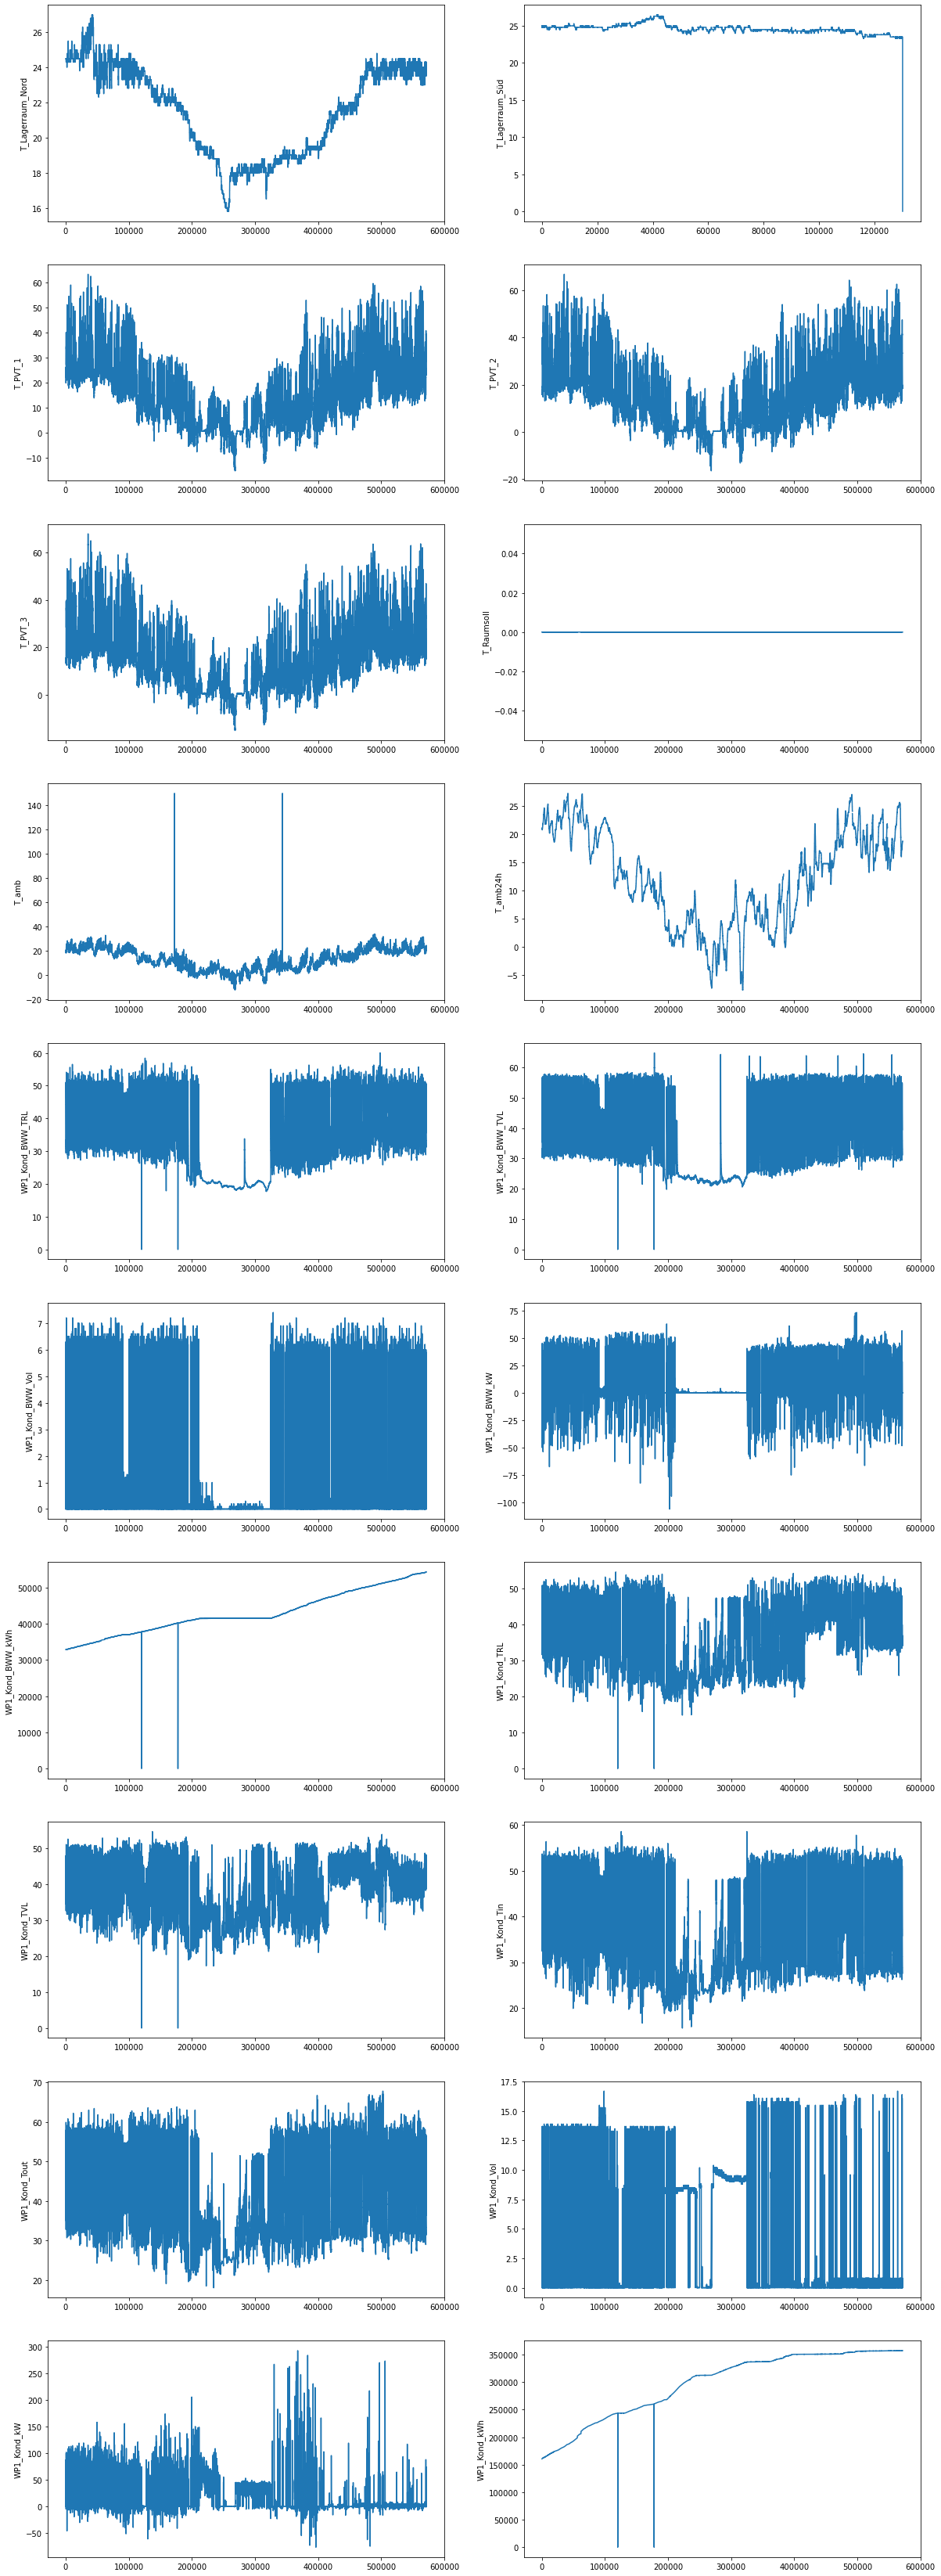

In [22]:
i,j=0,0
PLOTS_PER_ROW = 2
fig, axs = plt.subplots(math.ceil(20/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))
for col in cols[120:140]:
    axs[i][j].plot(data_oblamatik[col])
    axs[i][j].set_ylabel(col)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()

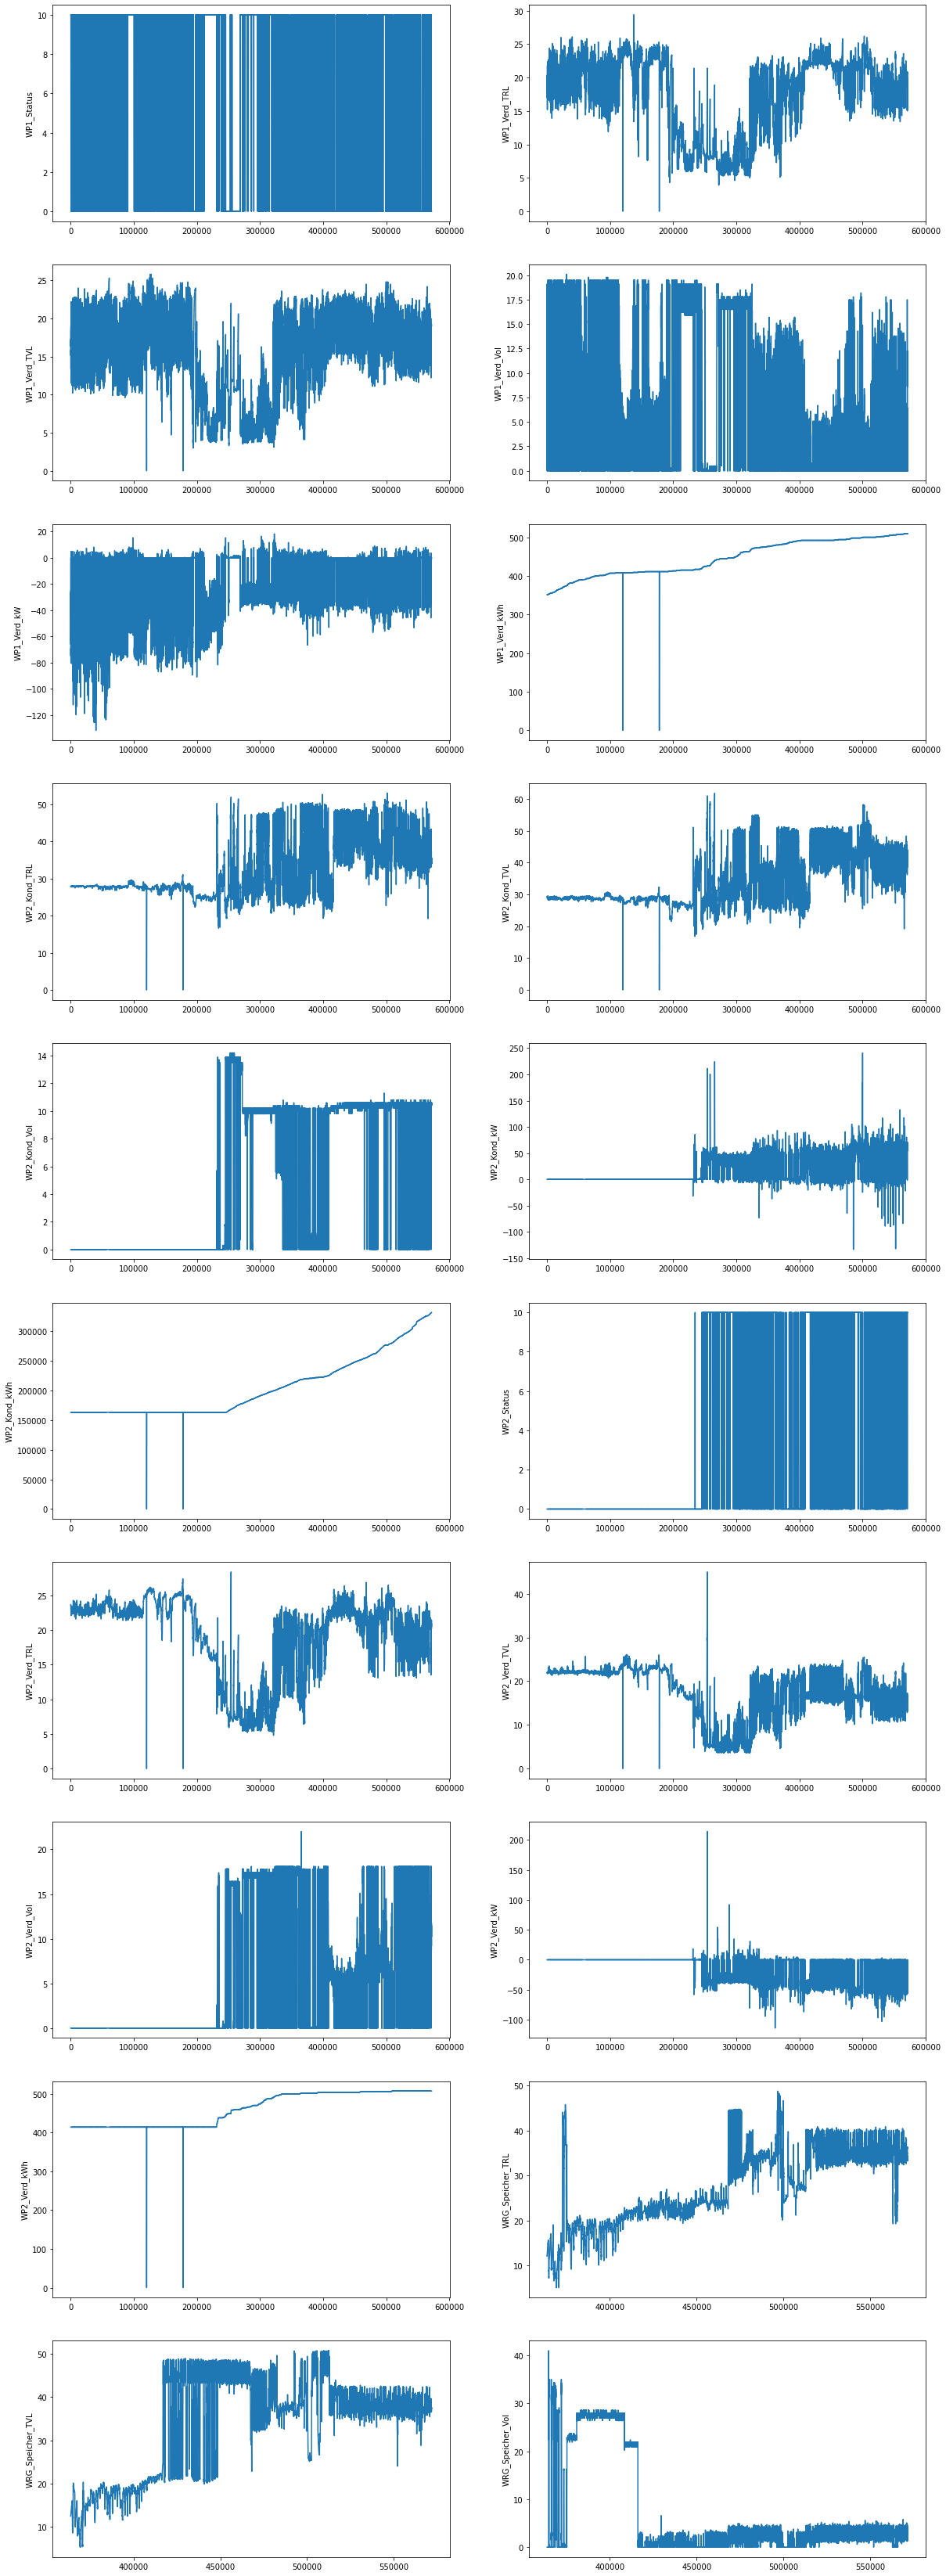

In [23]:
i,j=0,0
PLOTS_PER_ROW = 2
fig, axs = plt.subplots(math.ceil(20/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))
for col in cols[140:160]:
    axs[i][j].plot(data_oblamatik[col])
    axs[i][j].set_ylabel(col)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()

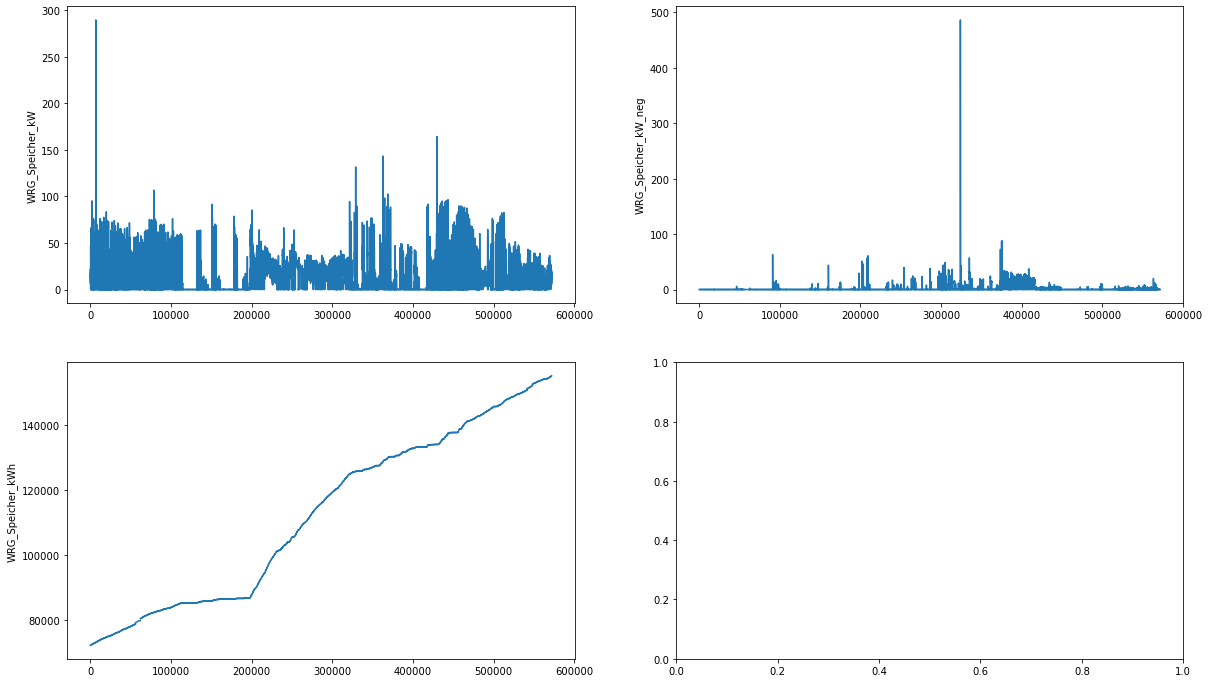

In [26]:
i,j=0,0
PLOTS_PER_ROW = 2
fig, axs = plt.subplots(math.ceil(3/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 12))
for col in cols[160:]:
    axs[i][j].plot(data_oblamatik[col])
    axs[i][j].set_ylabel(col)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()